In [1]:
import os, re, math
from PIL import Image,ImageDraw,ImageFont
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep, BSpline
matplotlib.rcParams['xtick.labelsize'] = 14 
matplotlib.rcParams['ytick.labelsize'] = 14 
sns.set_theme(style='white')
matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["figure.figsize"] = (8,7)
#%matplotlib notebook
import matplotlib.ticker as mticker
from scipy.interpolate import interp1d
def color20():
# These are the "Tableau 20" colors as RGB.
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
    for i in range(len(tableau20)):
           r, g, b = tableau20[i]
           tableau20[i] = (r / 255., g / 255., b / 255.)
    return tableau20
sns.set(style="white")
tableau20 = color20() 

# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
def log_tick_formatter_linear(val, pos=None):
    e = np.floor(np.log10(val+1))
    v = round(val/10**e, 1)
    return f"${v}\\times10^{int(e)}$"  
def log_tick_formatter_linear_int(val, pos=None):
    e = np.floor(np.log10(val+1))
    v = round(val/10**e, 1)
    return f"$10^{{{int(e)}}}$"  

# Figure 1: phase diagram and dynamics

/tmp/ipykernel_111460/2141628533.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()


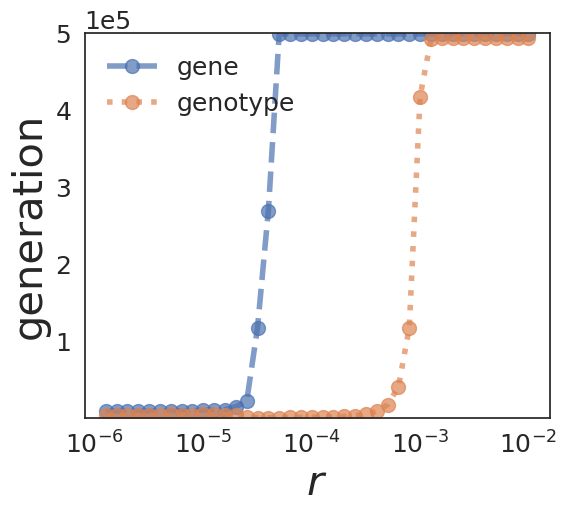

In [2]:
df =pd.read_csv("Data4Plot/phage_diagram_T_Nconstraint.txt")
i=0
%matplotlib inline
plt.figure(figsize=(6,5))
titles = ["phage-host", "phage-phage"]
for rname in ["rH_phagehost"]:
    for N in [10**6]:
        for T in [5*10**5]:
            for constraint in ["no"]:# "no"]:
                for L in [40]:
                    for J in  [0.005]: #set(df["J"]):
                        data = df[(df["L"] == L) & (df["J"] == J) & (df["NY"] == N) & (df[rname]!=0) & (df["simulation_time"]==T)& (df["constraint"]==constraint)]
                        data = data.groupby(rname).mean()
                        x, y = data.index, data["GenePersisentTime"]
                        #x, y = data[rname]*N/L, data["GenePersisentTime"]
                        inds = np.argsort(x)
                        #print(x, y)
                        plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o",linewidth = 4, markersize=10, linestyle="dashed", alpha=0.7, label="gene")
                        K = L*(L-1)/2
                        x, y = data.index, data["persTimeHost"]
                        plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o",linewidth = 4, markersize=10, linestyle="dotted", label="genotype", alpha=0.7)
            i+=1

plt.legend(fontsize=18,  frameon=False)
plt.ylim((10**3, 5.01*10**5))
ax = plt.gca()
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter_linear))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.offsetText.set(size=18)
plt.xlabel(r"$r$",fontsize =30)
plt.ylabel(r"generation",fontsize =30)
plt.xscale("log")
plt.savefig("phase_transition.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [3]:
df_gene =pd.read_csv("Data4Plot/phase_critical_r_gene_phagehost_ratio.txt")
df_gene["r_ratio"] = df_gene['rH_phagehost']/df_gene['rR_hosthost']
df_gene["N_ratio"] = df_gene['NY']/df_gene['NX']

df_genotype =pd.read_csv("Data4Plot/phase_critical_r_genotype_phagehost_ratio.txt")
df_genotype["r_ratio"] = df_genotype['rH_phagehost']/df_genotype['rR_hosthost']
df_genotype["N_ratio"] = df_genotype['NY']/df_genotype['NX']

/tmp/ipykernel_111460/1961236336.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_gene = data_gene.groupby(['Jprop']).mean()
/tmp/ipykernel_111460/1961236336.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_genotype = data_genotype.groupby(['Jprop']).mean()


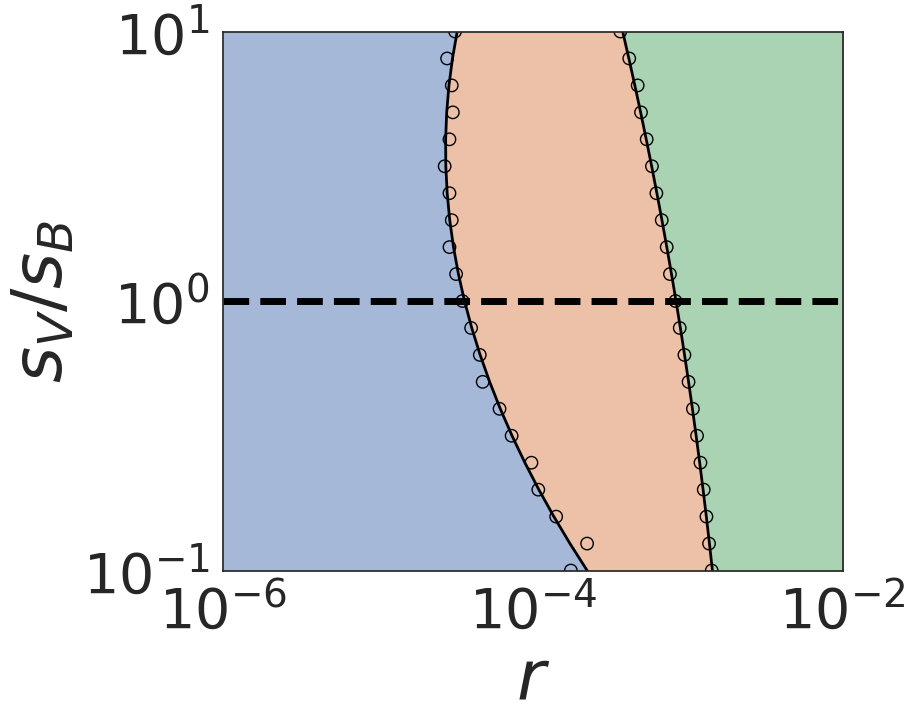

In [4]:
data_gene=df_gene[(df_gene["r_ratio"]==1)&(df_gene["N_ratio"]==1)]

data_gene = data_gene.groupby(['Jprop']).mean()
data_gene.reset_index(inplace=True)

data_genotype=df_genotype[(df_genotype["r_ratio"]==1)&(df_genotype["N_ratio"]==1)]
data_genotype = data_genotype.groupby(['Jprop']).mean()
data_genotype.reset_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111)
x, y = np.log10(data_gene.rR_hosthost), np.log10(data_gene.Jprop)
sort_ind = np.argsort(y)
x, y = x[sort_ind], y[sort_ind]
f = make_interp_spline(y, x, k=3)
f = interp1d(y, x)
tck_s_gene = splrep(y, x, s=5)
ax.plot(BSpline(*tck_s_gene)(y), y, linestyle="solid",linewidth=2,color="black")
ax.fill_betweenx(y, -6, BSpline(*tck_s_gene)(y),alpha=0.5)


x, y = np.log10(data_genotype.rR_hosthost), np.log10(data_genotype.Jprop)
sort_ind = np.argsort(y)
x, y = x[sort_ind], y[sort_ind]
f = make_interp_spline(y, x, k=3)
f = interp1d(y, x)
tck_s_genotype = splrep(y, x, s=5)
ax.plot(BSpline(*tck_s_genotype)(y), y, linestyle="solid",linewidth=2,color="black")
ax.fill_betweenx(y, BSpline(*tck_s_gene)(y), BSpline(*tck_s_genotype)(y),alpha=0.5)

ax.fill_betweenx(y, BSpline(*tck_s_genotype)(y),alpha=0.5)

ax.scatter(np.log10(data_genotype.rR_hosthost), np.log10(data_genotype.Jprop), s=80, edgecolor="black",facecolor="none")
ax.scatter(np.log10(data_gene.rR_hosthost), np.log10(data_gene.Jprop), s=80, edgecolor="black",facecolor="none")
ax.axhline(y = 0, color = 'black', linestyle = "dashed",linewidth=5)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.set_xlim([-6, -2])
ax.set_ylim([-1, 1.])
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_xlabel(r"$r$", fontsize=50)
ax.set_ylabel(r"$s_V/s_B$", fontsize=50)
plt.savefig("gene_persistencetime_s_ratio.pdf", dpi=300, bbox_inches='tight')

/tmp/ipykernel_113649/1287646128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gene['r_ratio'] = data_gene['r_ratio'].round(4)
/tmp/ipykernel_113649/1287646128.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_gene = data_gene.groupby(['r_ratio']).mean()
/tmp/ipykernel_113649/1287646128.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

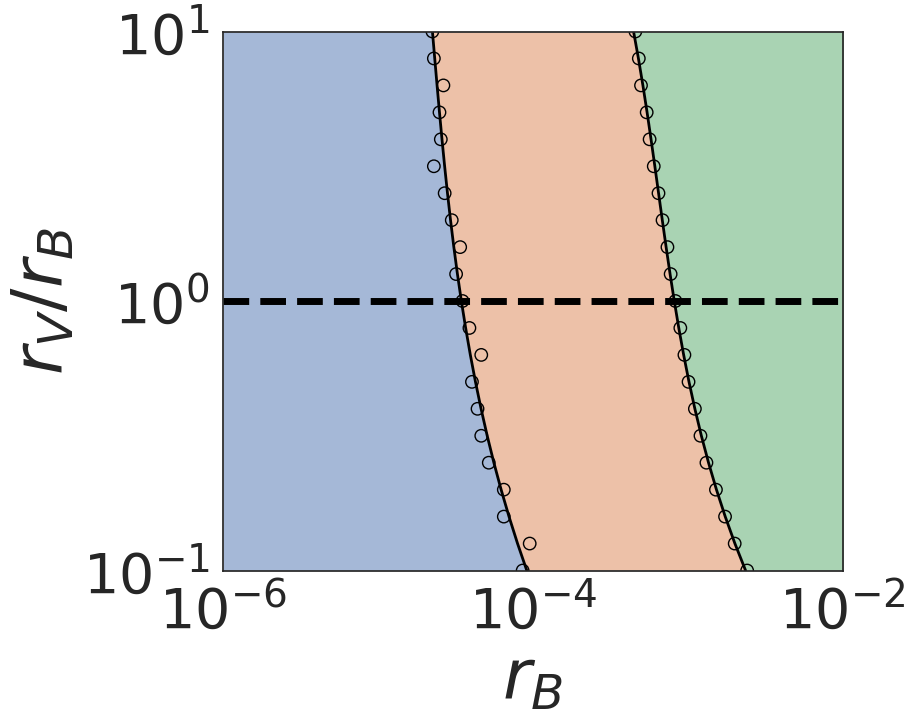

In [4]:
data_gene=df_gene[(df_gene["Jprop"]==1)&(df_gene["N_ratio"]==1)]
data_gene['r_ratio'] = data_gene['r_ratio'].round(4)
data_gene = data_gene.groupby(['r_ratio']).mean()
data_gene.reset_index(inplace=True)

data_genotype=df_genotype[(df_genotype["Jprop"]==1)&(df_genotype["N_ratio"]==1)]
data_genotype['r_ratio'] = data_genotype['r_ratio'].round(4)
data_genotype = data_genotype.groupby(['r_ratio']).mean()
data_genotype.reset_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111)
x, y = np.log10(data_gene.rR_hosthost), np.log10(data_gene.r_ratio)
sort_ind = np.argsort(y)
x, y = x[sort_ind], y[sort_ind]
f = make_interp_spline(y, x, k=3)
f = interp1d(y, x)
tck_s_gene = splrep(y, x, s=5)
ax.plot(BSpline(*tck_s_gene)(y), y, linestyle="solid",linewidth=2,color="black")
ax.fill_betweenx(y, -6, BSpline(*tck_s_gene)(y),alpha=0.5)


x, y = np.log10(data_genotype.rR_hosthost), np.log10(data_genotype.r_ratio)
sort_ind = np.argsort(y)
x, y = x[sort_ind], y[sort_ind]
f = make_interp_spline(y, x, k=3)
f = interp1d(y, x)
tck_s_genotype = splrep(y, x, s=5)
ax.plot(BSpline(*tck_s_genotype)(y), y, linestyle="solid",linewidth=2,color="black")
ax.fill_betweenx(y, BSpline(*tck_s_gene)(y), BSpline(*tck_s_genotype)(y),alpha=0.5)

ax.fill_betweenx(y, BSpline(*tck_s_genotype)(y),alpha=0.5)

ax.scatter(np.log10(data_genotype.rR_hosthost), np.log10(data_genotype.r_ratio), s=80, edgecolor="black",facecolor="none")
ax.scatter(np.log10(data_gene.rR_hosthost), np.log10(data_gene.r_ratio), s=80, edgecolor="black",facecolor="none")
ax.axhline(y = 0, color = 'black', linestyle = "dashed",linewidth=5)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_xlabel(r"$r_B$", fontsize=50)
ax.set_ylabel(r"$r_V/r_B$", fontsize=50)

ax.set_xlim([-6, -2])
ax.set_ylim([-1, 1.])
plt.savefig("gene_persistencetime_r_ratio.pdf", dpi=300, bbox_inches='tight')

/tmp/ipykernel_111460/2623067846.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_gene = data_gene.groupby(['N_ratio']).mean()
/tmp/ipykernel_111460/2623067846.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_genotype = data_genotype.groupby(['N_ratio']).mean()


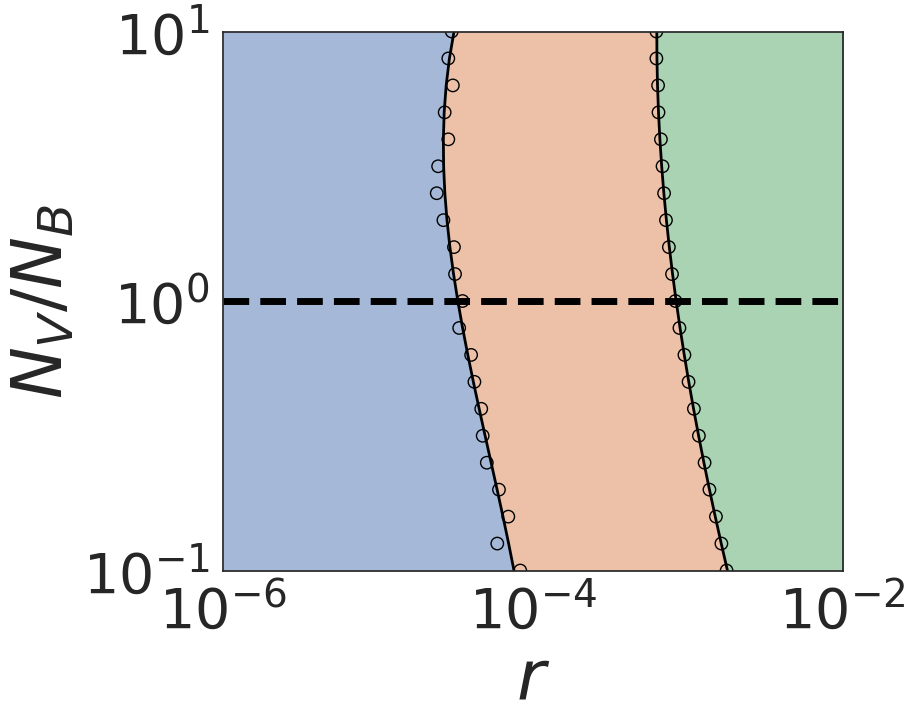

In [6]:
data_gene=df_gene[(df_gene["Jprop"]==1)&(df_gene["r_ratio"]==1)]
data_gene = data_gene.groupby(['N_ratio']).mean()
data_gene.reset_index(inplace=True)

data_genotype=df_genotype[(df_genotype["Jprop"]==1)&(df_genotype["r_ratio"]==1)]
data_genotype = data_genotype.groupby(['N_ratio']).mean()
data_genotype.reset_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111)
x, y = np.log10(data_gene.rR_hosthost), np.log10(data_gene.N_ratio)
sort_ind = np.argsort(y)
x, y = x[sort_ind], y[sort_ind]
tck_s_gene = splrep(y[:], x[:], s=6)
ax.plot(BSpline(*tck_s_gene)(y), y, linestyle="solid",linewidth=2,color="black")
ax.fill_betweenx(y, -6, BSpline(*tck_s_gene)(y),alpha=0.5)


x, y = np.log10(data_genotype.rR_hosthost), np.log10(data_genotype.N_ratio)
sort_ind = np.argsort(y)
x, y = x[sort_ind], y[sort_ind]
f = make_interp_spline(y, x, k=3)
f = interp1d(y, x)
tck_s_genotype = splrep(y, x, s=5)
ax.plot(BSpline(*tck_s_genotype)(y), y, linestyle="solid",linewidth=2,color="black")
ax.fill_betweenx(y, BSpline(*tck_s_gene)(y), BSpline(*tck_s_genotype)(y),alpha=0.5)

ax.fill_betweenx(y, BSpline(*tck_s_genotype)(y),alpha=0.5)

ax.scatter(np.log10(data_genotype.rR_hosthost), np.log10(data_genotype.N_ratio), s=80, edgecolor="black",facecolor="none")
ax.scatter(np.log10(data_gene.rR_hosthost), np.log10(data_gene.N_ratio), s=80, edgecolor="black",facecolor="none")
ax.axhline(y = 0, color = 'black', linestyle = "dashed",linewidth=5)

ax.set_xlim([-6, -2])
ax.set_ylim([-1, 1.])
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_xlabel(r"$r$", fontsize=50)
ax.set_ylabel(r"$N_V/N_B$", fontsize=50)
plt.savefig("gene_persistencetime_N_ratio.pdf", dpi=300, bbox_inches='tight')

# Figure 2: Scaling of temperature $\Theta$ and $\theta$

/tmp/ipykernel_111460/2926324523.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/2926324523.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/2926324523.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/2926324523.py:10: FutureWarning: The de

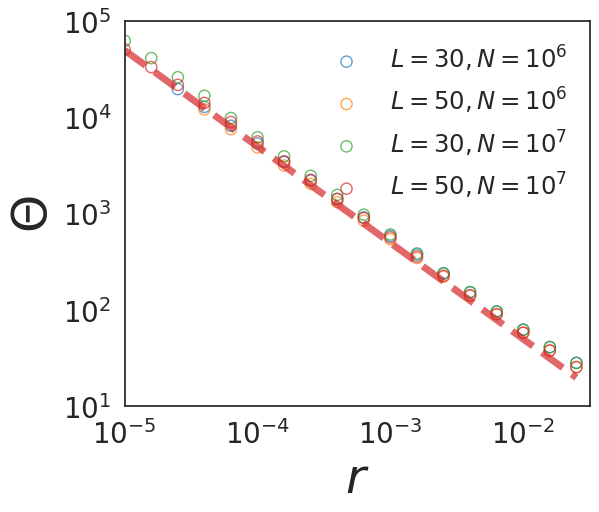

In [7]:
df =pd.read_csv("Data4Plot/diff_genetransf_rL.txt")
count = 0
i =0 
for rname in ["rH_phagehost"]:
    plt.figure(figsize=(6,5))
    for N in [10**6, 10**7]:
        for L in [30, 50]:
            for J in  [0.005]: #set(df["J"]):
                data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                data = data.groupby(rname).mean()
                x, y = data.index, data["theta_GH"]
                #x = data.index*N/L
                #y = N*(2*data.index)/(L)
                inds = np.argsort(x)
                #print(x, y)
                plt.scatter(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o", label=r"$L={0:d}, N=10^{1:d}$".format(int(L), int(np.log10(N))),alpha=0.7, s=65, facecolors='none', edgecolors= tableau20[i])
                i += 2
                #x = np.logspace(-2,-1., 30)
                #plt.plot(x, 1/(x),linewidth=5, linestyle="dashed",color="tab:red")
                #plt.plot(x, 1/(x**0.5),linewidth=5, linestyle="dashed",color="tab:red")
               # plt.plot(x, L/x,linewidth=5, linestyle="dashed", color="tab:red") #color=plt.gca().lines[-1].get_color())
    x = np.logspace(-5.,-1.6, 30)
    plt.plot(x, 1/(2*x),linewidth=5, linestyle="dashed",color="tab:red",alpha=0.7)
   #plt.plot(x, 4/(x**0.5),linewidth=5, linestyle="dashed",color="tab:red")
   # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.xlabel(r"$r$",fontsize =35)
    plt.ylabel(r"$\Theta$",fontsize =35)
    #plt.title("genotype persistence time",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((10**-5, 10**-1.5))
    plt.ylim((10**1.,10**5))
    if count>-1:
        #plt.legend(fontsize=13, loc="lower left")
        count +=1
    plt.legend(fontsize=17.5,  frameon=False)
    plt.savefig("GenotypeTheta"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_111460/157483314.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/157483314.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/157483314.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/157483314.py:10: FutureWarning: The defaul

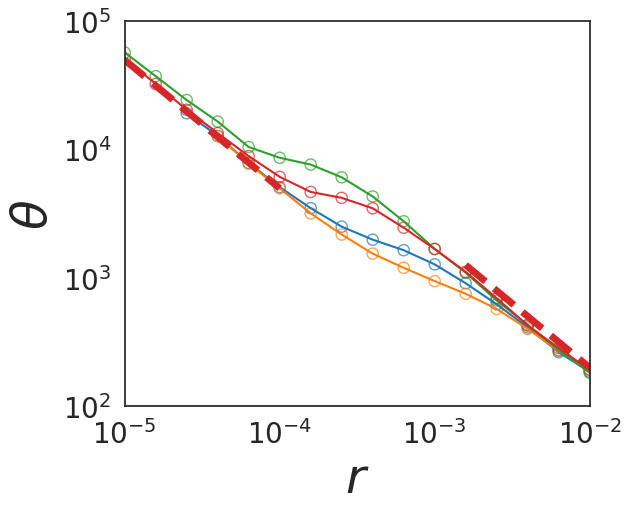

In [8]:
df =pd.read_csv("Data4Plot/diff_genetransf_rL.txt")
count = 0
i = 0 
for rname in ["rH_phagehost"]:
    plt.figure(figsize=(6,5))
    for N in [10**6, 10**7]:
        for L in [30, 50]:
            for J in  [0.005]: #set(df["J"]):
                data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                data = data.groupby(rname).mean()
                x, y = data.index, data["theta_gH"]
                #x = data.index*N/L
                #y = N*(2*data.index)/(L)
                inds = np.argsort(x)
                #print(x, y)
                plt.scatter(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o", label="L={0:d}, N={1:0.0e}, J={2:d}".format(int(L), N, int(J)),alpha=0.7, s=65, facecolors='none', edgecolors= tableau20[i])
                plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], c= tableau20[i])
                i += 2
    x = np.logspace(-5, -4, 30)
   # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.plot(x, 1/(2*x),linewidth=5, linestyle="dashed",color="tab:red")
    x = np.logspace(-2.8, -1.8, 30)
   # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.plot(x, 2./x,linewidth=5, linestyle="dashed",color="tab:red")
       # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.xlabel(r"$r$",fontsize =35)
    plt.ylabel(r"$\theta$",fontsize =35)
    #plt.title("genotype persistence time",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((10**-5, 10**-2.))
    plt.ylim((10**2.,10**5))
    #plt.ylim((0,500))
    #plt.ylim((100,500))
    #plt.xlim((10**-2.2, 10**-1.5))
    if count>-1:
        #plt.legend(fontsize=15)
        count +=1
    plt.savefig("Genetheta"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Figure 4: critical gene transfer rates

## Gene

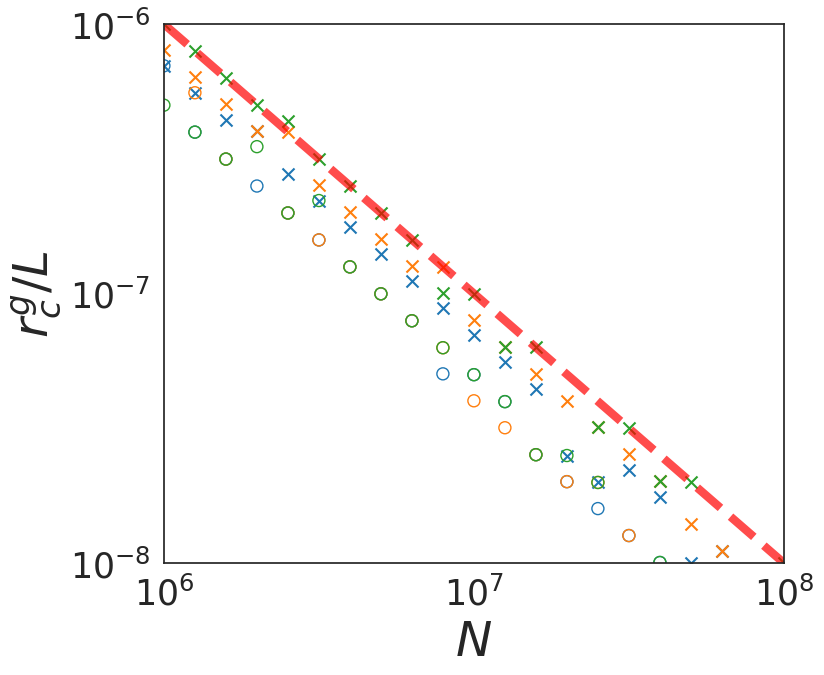

In [9]:
df =pd.read_csv("Data4Plot/phase_critical_r_gene.txt")
i=0
for L in [10, 15, 20]:
    c = tableau20[i]
    i += 2
    d = 2
    data = df[(df["L"]==L) & (df["d"]==d)]
   # plt.scatter(data.NX, (2*data.NX/L)/data.theta_gH-1,marker="o",s=75,facecolors='none',edgecolors=c)
    scatter = plt.scatter(data.NX, data.rH_phagehost/L, label="L="+str(L), facecolors='none',edgecolors=c, marker="o", s=75)
    d = 3
    data = df[(df["L"]==L) & (df["d"]==d)]
    plt.scatter(data.NX, data.rH_phagehost/L,marker="x",s=75, c= scatter.get_edgecolor())
    #plt.scatter(data.NX, (3*data.NX/L)/data.theta_gH-1,marker="x",s=75, c= scatter.get_edgecolor())
N = np.logspace(6.0, 8.0, num=100)
plt.plot(N, 1/(N), linewidth = 6, color="red", linestyle="dashed",alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$",fontsize =35)
plt.ylabel(r"$r_c^g/L$",fontsize =35)
#plt.legend(fontsize=35,  frameon=False)
plt.xlim(10**6, 10**8)
plt.ylim(10**-8, 10**-6.)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.savefig("critical_r_gene.pdf", dpi=300, bbox_inches='tight')
#plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

## Genotype

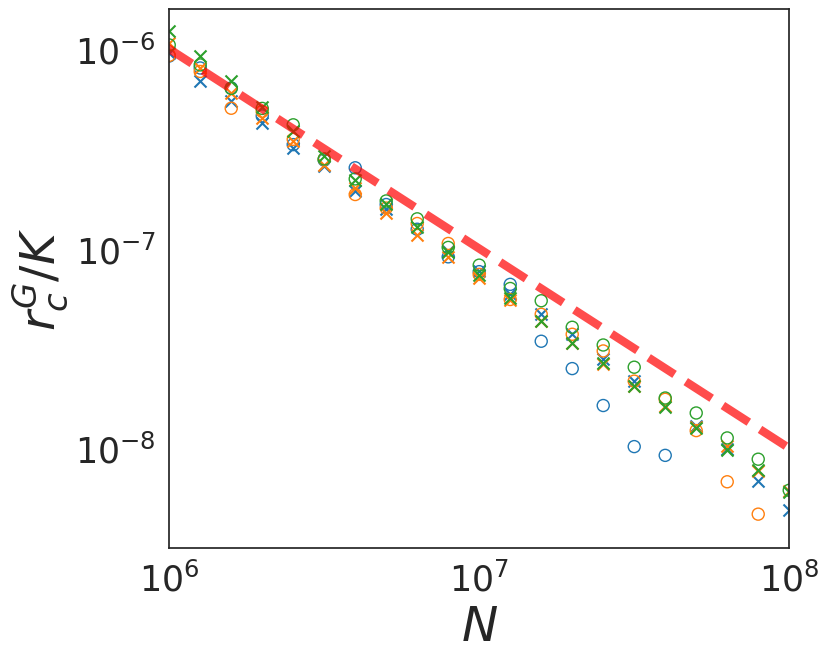

In [10]:
i = 0
for L in [10, 15,  20]:
    N = np.logspace(5.0, 8.0, num=100)
    d = 2
    df =pd.read_csv("Data4Plot/phase_critical_r_genotype.txt")
    data = df[(df["L"]==L) & (df["d"]==d)]
    K = L*(L-1)/2
    c = tableau20[i]
    i += 2
    scatter = plt.scatter(data.NX, data.rH_phagehost/K, label="L="+str(L), facecolors='none',edgecolors=c, marker="o", s=75)
   # plt.plot(N, 1/(N))
    
    d = 3
    df =pd.read_csv("Data4Plot/phase_critical_r_genotype_tripleton.txt")
    K = L*(L-1)*(L-2)/6
    data = df[(df["L"]==L) & (df["d"]==d)]
    plt.scatter(data.NX, data.rH_phagehost/K,marker="x",s=75, c= scatter.get_edgecolor())
plt.plot(N, 1/(N), linewidth = 6, color="red", linestyle="dashed",alpha=0.7)
             
plt.xscale("log")
plt.yscale("log")
#plt.legend(fontsize=25)
plt.xlabel(r"$N$",fontsize =35)
plt.ylabel(r"$r_c^G/K$",fontsize =35)
#plt.legend(fontsize=35,  frameon=False)
plt.xlim(10**6, 10**8)
plt.ylim(10**-8.5, 10**-5.8)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.savefig("critical_r_genotype.pdf", dpi=300, bbox_inches='tight')

# Figure S1: extinction

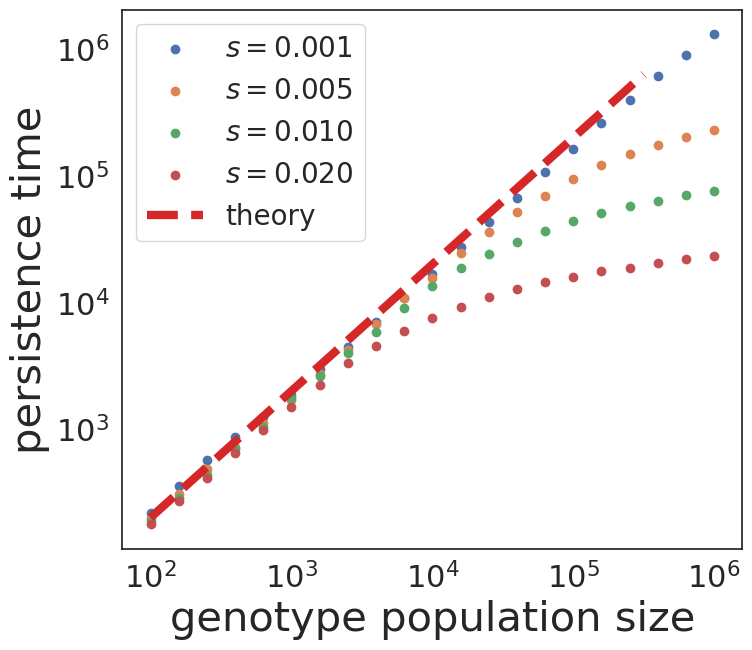

In [11]:
df =pd.read_csv("Data4Plot/singlepair_extinctiontimev4.txt")
plt.figure(figsize=(8,7))
for J in sorted(list(set(df.J)))[0:4]:
    data = df[df["J"]==J]
    plt.scatter(data.N ,data['extinction time'],label="$s={:0.3f}$".format(J))
plt.xlabel("genotype population size", fontsize=30)
plt.ylabel("persistence time", fontsize=30)
x=np.logspace(2., 5.5, num=10)
plt.plot(x, 2*x, linewidth=6, c="tab:red",linestyle="dashed",label="theory")
plt.tick_params(axis='both', which='major', labelsize=22)
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=20)
plt.savefig("singlepair_persistencetime.pdf", dpi=300, bbox_inches='tight')

# Figure S2: diffferent parameters for phages and hosts

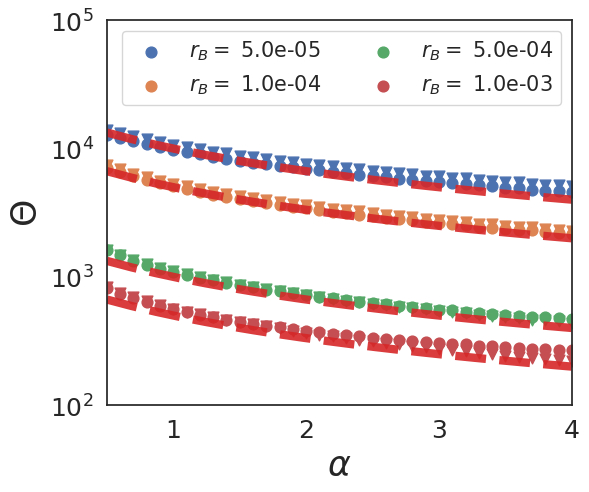

In [12]:
df =pd.read_csv("Data4Plot/Check_diff_r1.txt")
fig, ax = plt.subplots(figsize=(6,5))
for L in [40]:
        for J in [0.005]:
            for r in [5*10**-5, 10**-4,5*10**-4,10**-3]:
                feature1, feature2 ='rR_hosthost', "rH_phagehost"
                data = df[(df["L"] == L) & (df["J"] == J) & (df[feature1]==r)]
                x, y = data[feature2], data["theta_GH"]
                color = next(ax._get_lines.prop_cycler)['color']
                ax.scatter(x/r, y, color= color, marker="o",s=60, label="$r_B=$ {:0.1e}".format(r))
                x, y = data[feature2], data["theta_GP"]
                ax.scatter(x/r, y, color= color, marker="v",s=60)
                x = np.linspace(0.5, 4, 20)
                x = np.linspace(0.5, 4.,20)
                ax.plot(x, 1/(1+x)/r,linewidth=6, linestyle="--",alpha=0.9, color= "tab:red")
ax.set_xlabel(r"$\alpha$",fontsize =25)
ax.set_ylabel(r"$\Theta$",fontsize =25)
ax.set_ylim([10**2, 10**5])
ax.set_xlim([0.5, 4])
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(fontsize=15,ncol=2)
plt.savefig("r_different_weak_strong.pdf", dpi=300, bbox_inches='tight')
plt.show()

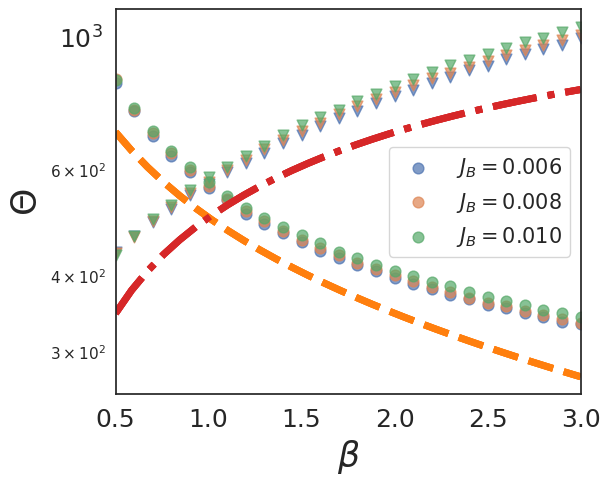

In [13]:
df =pd.read_csv("Data4Plot/Check_diff_J1.txt")
fig, ax = plt.subplots(figsize=(6,5))
for L in [40]:
    for J in [0.006, 0.008, 0.01]:
        for r in [10**-3]:
            for feature in ["rH_phagehost"]:
                N = 10**6
                feature = "rH_random"
                feature = "rH_phagehost"
                data = df[(df["L"] == L)& (df["J"] == J) & (df[feature] == r) & (df["NX"] == N)]
                x, y1 = data["Jprop"], data["theta_GH"]
                color = next(ax._get_lines.prop_cycler)['color']
                ax.scatter(x, y1, color= color, marker="o",label="$J_B={:0.3f}$".format(J), alpha=0.7, s=60)
                x, y2 = data["Jprop"], data["theta_GP"]
                ax.scatter(x, y2, color= color, marker="v", alpha=0.7, s=60)
                n = 2*N/(L*(L-1))
                x = np.linspace(0.5,3, 30)
                ax.plot(x, (1+x**2+4*x*n*r -np.sign(n*r-1)*np.sqrt(1+x**4+2*x**2*(1+8*n*r*(n*r-1))))/(4*(x**2+x)*r),linewidth=5, linestyle="--", c= "tab:orange")
                ax.plot(x, (1+x**2+4*x*n*r -np.sign(n*r-1)*np.sqrt(1+x**4+2*x**2*(1+8*n*r*(n*r-1))))/(4*(x+1)*r),linewidth=5, linestyle="-.", c= "tab:red")
ax.set_xlabel(r"$\beta$",fontsize =25)
ax.set_ylabel(r"$\Theta$",fontsize =25)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_yscale("log")
ax.legend(fontsize=15)
ax.set_xlim([0.5,3])
plt.savefig("J_different_phagehost_strong.pdf", dpi=300, bbox_inches='tight')
plt.show()

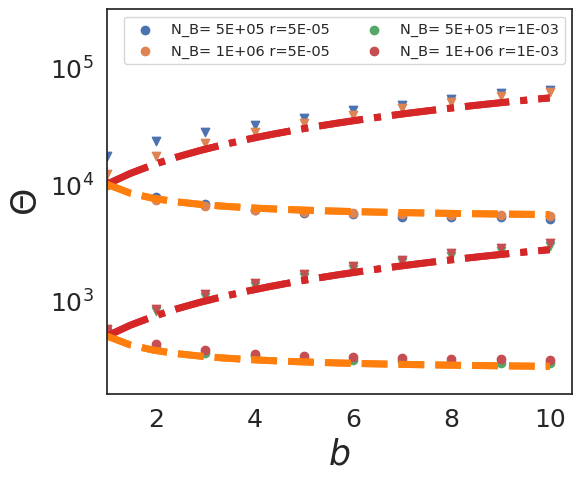

In [14]:
df =pd.read_csv("Data4Plot/Check_diff_N1.txt")
fig, ax = plt.subplots(figsize=(6,5))
for L in [40]:
    for J in [0.01]:
        for r in [5*10**-5, 1*10**-3]:
            for NX in [5*10**5, 10**6]:
                data = df[(df["L"] == L)& (df["J"] == J) & (df["NX"] == NX) & (df["rH_phagehost"] == r)]
                x, y1 = np.array(data["NY"])/np.array(data["NX"]), data["theta_GH"]
                color = next(ax._get_lines.prop_cycler)['color']
                ax.scatter(x, y1, color= color, marker="o",label="N_B= {0:.0E} r={1:.0E}".format(NX, r))
                x, y2 = np.array(data["NY"])/np.array(data["NX"]), data["theta_GP"]
                ax.scatter(x, y2, color= color, marker="v")
                x = np.linspace(1.,10, 20)
                ax.plot(x,(1+x)/(4*r),linewidth=5, linestyle="-.", c= "tab:red")
                ax.plot(x,(1+1/x)/(4*r),linewidth=5, linestyle="dashed", c= "tab:orange")
ax.set_xlabel(r"$b$",fontsize =25)
ax.set_ylabel(r"$\Theta$",fontsize =25)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_yscale("log")
ax.set_xlim(left=1)
ax.set_ylim([10**2.2, 10**5.5])
ax.legend(fontsize=10.5, ncols=2)
#ax.set_yticks(ax.get_yticks()[::2])
plt.savefig("N_different.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Figure S4: boom-bust cycles

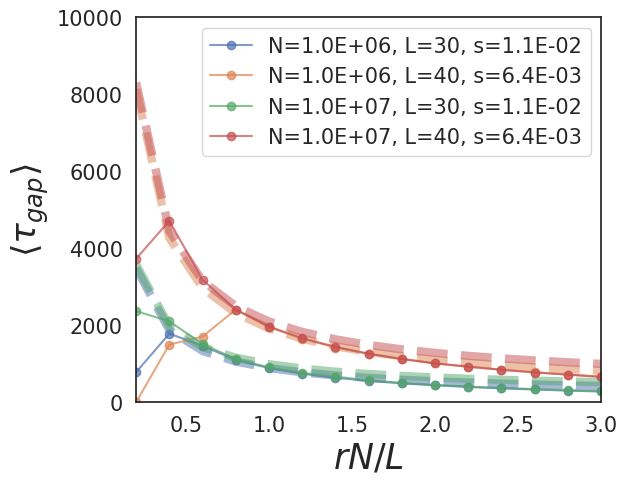

In [15]:
df =pd.read_csv("Data4Plot/Branching_gapANDpeakDuration.txt")
count = 0
for rname in ["rH_phagehost"]:
    plt.figure(figsize=(6,5))
    for N in [10**6, 10**7]:
        for L in [30, 40]:
            for J in [5]:
                    data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                    data = data.groupby(rname).mean()
                    x, y = data.index*N/L, data["gapTimePhage"]
                    inds = np.argsort(x)
                    K = (L**2-L)/2
                    s = J/K
                    plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o", label="N={0:0.1E}, L={1:d}, s={2:0.1E}".format(N, int(L), s),alpha=0.7)
                    x0 = np.asarray(x)[inds]
                    x1 = x0*L/N
                    plt.plot(x0,1/(x1*N/K*s*2) + 1/(2*s)*np.log(s/x1),linewidth=6, linestyle="dashed", alpha=0.5, color=plt.gca().lines[-1].get_color())
    x = np.logspace(-4.8,-1., 30)
    plt.xlabel("$rN/L$",fontsize =25)
    plt.ylabel(r"$\left<\tau_{gap}\right>$",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim((0.2, 3))
    plt.ylim((0,10**4))
    if count>-1:
        plt.legend(fontsize=15)
        count +=1
    plt.savefig("PhageHost_gapTime"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

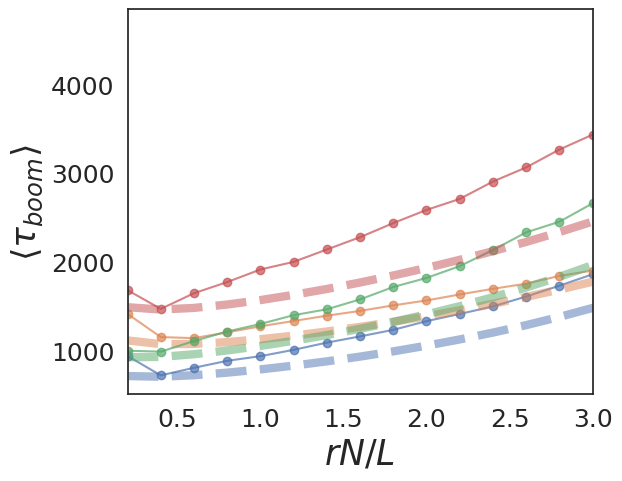

In [16]:
df =pd.read_csv("Data4Plot/Branching_gapANDpeakDuration.txt")
count = 0
for rname in ["rH_phagehost"]:
    plt.figure(figsize=(6,5))
    for N in [10**6, 10**7]:
        for L in [30, 40]:
            for J in [5]:
                    data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                    data = data.groupby(rname).mean()
                    x, y = data.index*N/L, data["persTimePhage"]
                    inds = np.argsort(x)
                    K = (L**2-L)/2
                    s = J/K
                    plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o", label="N={0:0.0E}, L={1:d}, s={2:0.0E}".format(N, int(L), s),alpha=0.7)
                    x0 = np.asarray(x)[inds]
                    x1 = x0*L/N
                    plt.plot(x0, 1/s*np.log(s/x1)+ 2/(J/N*(1/(2*x1)-N/K))*np.log(1/(2*x1)),alpha=0.5, linewidth=6, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    x = np.logspace(-4.8,-1., 30)
    plt.xlabel("$rN/L$",fontsize =25)
    plt.ylabel(r"$\left<\tau_{boom}\right>$",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.xlim((0.2, 3))
    if count>-1:
        count +=1
    plt.savefig("PhageHost_survivingduration"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

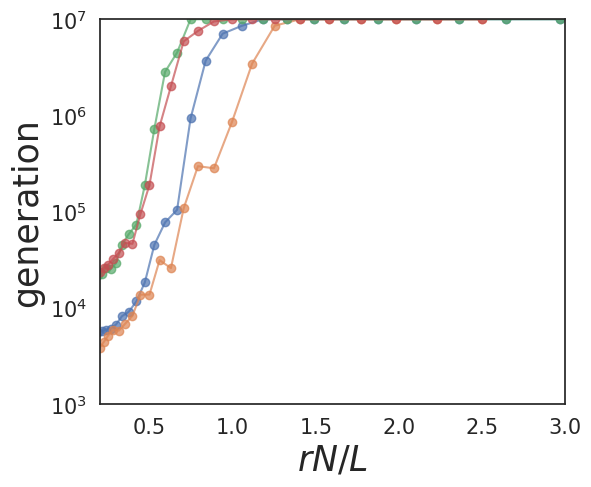

In [29]:
df =pd.read_csv("Data4Plot/DifferentSamplingWay_larger4.txt")
count = 0
for rname in ["rH_phagehost"]:
    plt.figure(figsize=(6,5))
    for N in [10**6, 10**7]:
        for L in [30, 40]:
            for J in [5]:
                    data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                    data = data.groupby(rname).mean()
                    x, y = data.index*N/L, data["GenePersisentTime"]
                    #x = data.index*N/L
                    #y = N*(2*data.index)/(L)
                    inds = np.argsort(x)
                    #print(x, y)
                    K = (L**2-L)/2
                    s = J/K
                    plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o", label="N={0:0.1E}, L={1:d}, s={2:0.1E}".format(N, int(L), s),alpha=0.7)
                
    x = np.logspace(-4.8,-1., 30)
    plt.xlabel("$rN/L$",fontsize =25)
    plt.ylabel(r"generation",fontsize =25)
    #plt.title("genotype persistence time",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim((0.2, 3))
    plt.ylim((10**3,10**7))
    plt.yscale("log")
    plt.savefig("PhageHost_gapTime"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Figure S5: temperature for different ways of gene transfer

## Infinite-islands migration

/tmp/ipykernel_111460/953859421.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/953859421.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/953859421.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/953859421.py:9: FutureWarning: The default va

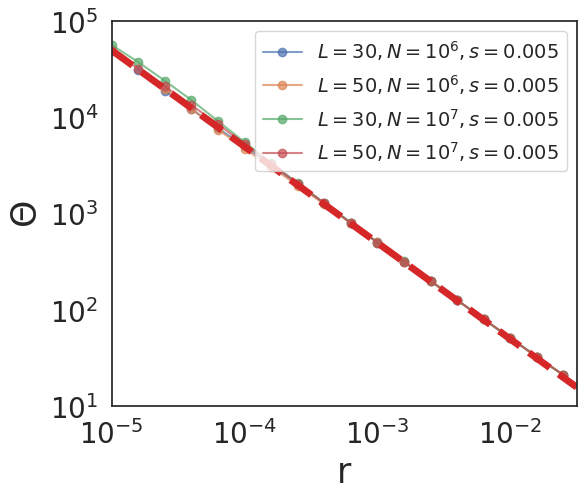

In [17]:
df =pd.read_csv("Data4Plot/diff_genetransf_rL.txt")
count = 0
for rname in ["rH_random"]:
    plt.figure(figsize=(6,5))
    for N in [10**6, 10**7]:
        for L in [30,  50]:
            for J in  [0.005]: #set(df["J"]):
                data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                data = data.groupby(rname).mean()
                x, y = data.index, data["theta_GH"]
                #x = data.index*N/L
                #y = N*(2*data.index)/(L)
                inds = np.argsort(x)
                #print(x, y)
                plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o", label=r"$L={0:d}, N=10^{1:d}, s={2:0.3f}$".format(int(L), int(np.log10(N)), J),alpha=0.7)
    x = np.logspace(-5, -1.5, 30)
   # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.plot(x, 1/(2*x),linewidth=5, linestyle="dashed",color="tab:red")
       # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.xlabel("r",fontsize =25)
    plt.ylabel(r"$\Theta$",fontsize =25)
    #plt.title("genotype persistence time",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((10**-5, 10**-1.5))
    plt.ylim((10**1.,10**5))
    if count>-1:
        plt.legend(fontsize=14)
        count +=1
    plt.savefig("Genotypetheta"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_111460/3100677902.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/3100677902.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/3100677902.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/3100677902.py:9: FutureWarning: The defaul

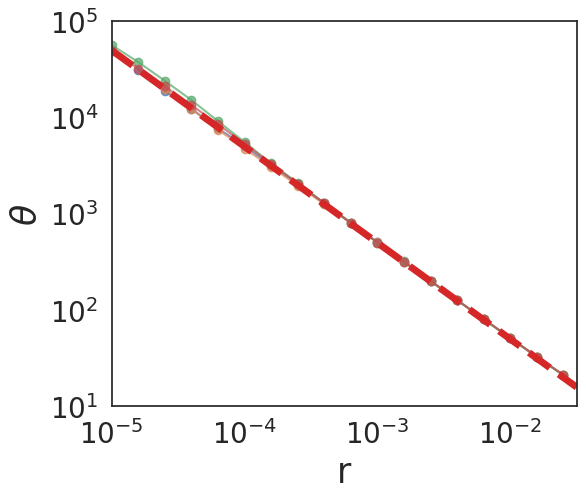

In [18]:
df =pd.read_csv("Data4Plot/diff_genetransf_rL.txt")
count = 0
for rname in ["rH_random"]:
    plt.figure(figsize=(6,5))
    for N in [10**6, 10**7]:
        for L in [30,  50]:
            for J in  [0.005]: #set(df["J"]):
                data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                data = data.groupby(rname).mean()
                x, y = data.index, data["theta_GH"]
                #x = data.index*N/L
                #y = N*(2*data.index)/(L)
                inds = np.argsort(x)
                #print(x, y)
                plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o", label="L={0:d}, N={1:0.0e}, J={2:d}".format(int(L), N, int(J)),alpha=0.7)
    x = np.logspace(-5, -1.5, 30)
   # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.plot(x, 1/(2*x),linewidth=5, linestyle="dashed",color="tab:red")
       # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.xlabel("r",fontsize =25)
    plt.ylabel(r"$\theta$",fontsize =25)
    #plt.title("genotype persistence time",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((10**-5, 10**-1.5))
    plt.ylim((10**1.,10**5))
    if count>-1:
       # plt.legend(fontsize=18)
        count +=1
    plt.savefig("Genetheta"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

## Phage-Phage

/tmp/ipykernel_111460/373544283.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/373544283.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/373544283.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/373544283.py:9: FutureWarning: The default va

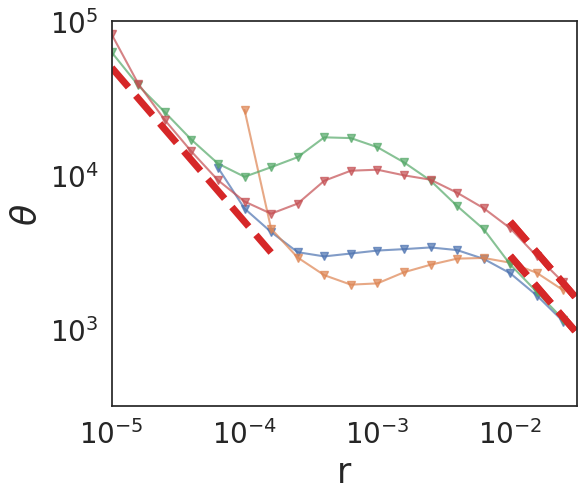

In [19]:
df =pd.read_csv("Data4Plot/diff_genetransf_rL.txt")
count = 0
for rname in ["rH_phagephage"]:
    plt.figure(figsize=(6,5))
    for N in [10**6, 10**7]:
        for L in [30,  50]:
            for J in  [0.005]: #set(df["J"]):
                data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                data = data.groupby(rname).mean()
                x, y = data.index, data["theta_gH"]
                #x = data.index*N/L
                #y = N*(2*data.index)/(L)
                inds = np.argsort(x)
                #print(x, y)
                plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "v", label="L={0:d}, N={1:0.0e}, J={2:d}".format(int(L), N, int(J)),alpha=0.7)
                x = np.logspace(-2.,-1.5, 30)
                #plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color="tab:red") #color=plt.gca().lines[-1].get_color())
                plt.plot(x, L/x,linewidth=5, linestyle="dashed", color="tab:red") #color=plt.gca().lines[-1].get_color())
    x = np.logspace(-5,-3.8, 30)
    #plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.plot(x, 1/(2*x),linewidth=5, linestyle="dashed",color="tab:red")
    plt.xlabel("r",fontsize =25)
    plt.ylabel(r"$\theta$",fontsize =25)
    #plt.title("genotype persistence time",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((10**-5, 10**-1.5))
    plt.ylim((10**2.5,10**5))
    if count>-1:
       # plt.legend(fontsize=15)
        count +=1
    plt.savefig("Genetheta"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_111460/325112388.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/325112388.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/325112388.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(rname).mean()
/tmp/ipykernel_111460/325112388.py:9: FutureWarning: The default va

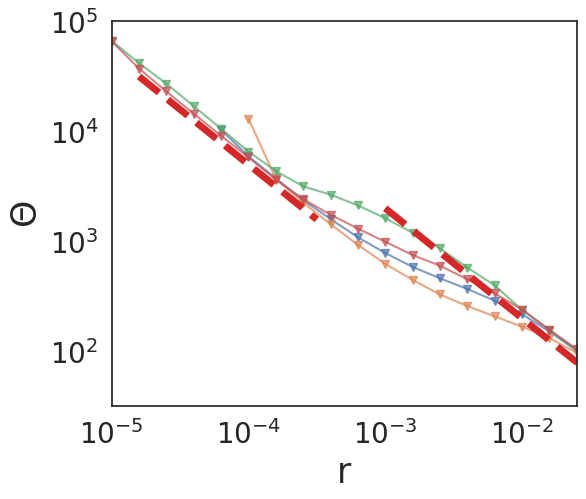

In [20]:
10**5
count = 0
for rname in ["rH_phagephage"]:
    plt.figure(figsize=(6,5))
    for N in [10**6, 10**7]:
        for L in [30, 50]:
            for J in  [0.005]: #set(df["J"]):
                data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                data = data.groupby(rname).mean()
                x, y = data.index, data["theta_GH"]
                #x = data.index*N/L
                #y = N*(2*data.index)/(L)
                inds = np.argsort(x)
                #print(x, y)
                plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "v",label="L={0:d}, N={1:d}, J={2:d}".format(int(L), int(np.log10(N)), int(J)),alpha=0.7)
        
    x = np.logspace(-4.8,-3.5, 30)
   # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.plot(x, 1/(2*x),linewidth=5, linestyle="dashed",color="tab:red")
    x = np.logspace(-3,-1.5, 30)
   # plt.plot(x, N*(1/L -np.sqrt(1/L**2-2/(N*x))),linewidth=5, linestyle="dashed", color=plt.gca().lines[-1].get_color())
    plt.plot(x, 2/(x),linewidth=5, linestyle="dashed",color="tab:red")
    plt.xlabel("r",fontsize =25)
    plt.ylabel(r"$\Theta$",fontsize =25)
    #plt.title("genotype persistence time",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((10**-5, 10**-1.6))
    plt.ylim((10**1.5,10**5))
    #plt.ylim((0,10))
    if count>-1:
        #plt.legend(fontsize=15)
        count +=1
    plt.savefig("GenotypeTheta"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Figure S6: Critical $r$ for different ways of gene transfer

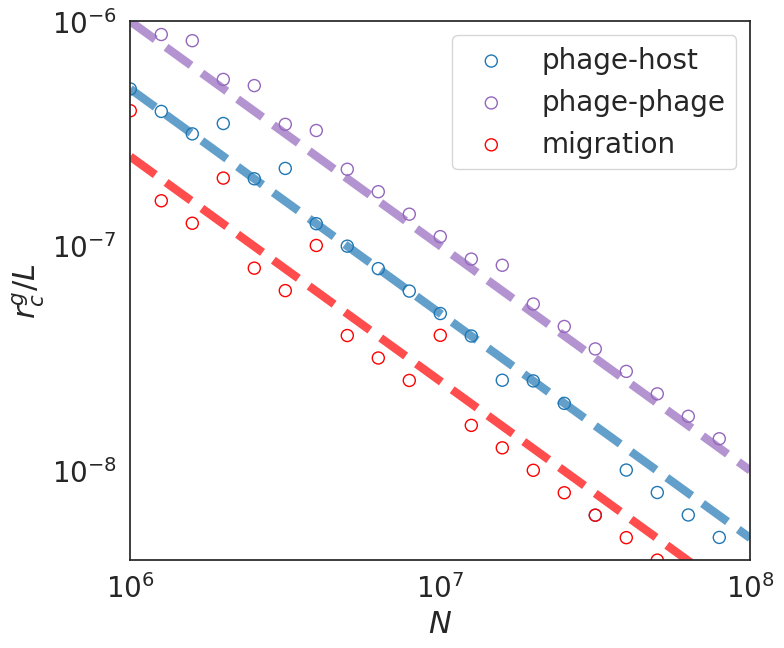

In [21]:
L = 20
d = 2
K = L*(L-1)/2
N = np.logspace(6.0, 8.0, num=100) 
c = tableau20[0]
df =pd.read_csv("Data4Plot/phase_critical_r_gene.txt")
data = df[(df["L"]==L) & (df["d"]==d)]
plt.scatter(data.NX, data.rH_phagehost/L, label="phage-host", facecolors='none',edgecolors=c, marker="o", s=75)
plt.plot(N, 1/(2*N), linewidth = 6, color=c, linestyle="dashed",alpha=0.7)

c = tableau20[8]
df =pd.read_csv("Data4Plot/phase_critical_r_gene_phagephage.txt")
data = df[(df["L"]==L) & (df["d"]==d)]
plt.scatter(data.NX, data.rH_phagephage/L, label="phage-phage", facecolors='none',edgecolors=c, marker="o", s=75)
plt.plot(N, 1/(N), linewidth = 6, color=c, linestyle="dashed",alpha=0.7)

c = tableau20[4]
df =pd.read_csv("Data4Plot/phase_critical_r_gene_random.txt")
data = df[(df["L"]==L) & (df["d"]==d)]
plt.scatter(data.NX, data.rH_random/L, label="migration", facecolors='none',edgecolors="red", marker="o", s=75)
plt.plot(N, 1/(4*N), linewidth = 6, color="red", linestyle="dashed",alpha=0.7)


plt.xscale("log")
plt.yscale("log")
plt.legend( fontsize=20)
plt.xlabel(r"$N$",fontsize =22)
plt.ylabel(r"$r_c^g/L$",fontsize =22)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(10**6, 10**8)
plt.ylim(10**-8.4, 10**-6)
plt.savefig("critical_r_gene_population_diff_gene_transfer.pdf", dpi=300, bbox_inches='tight')

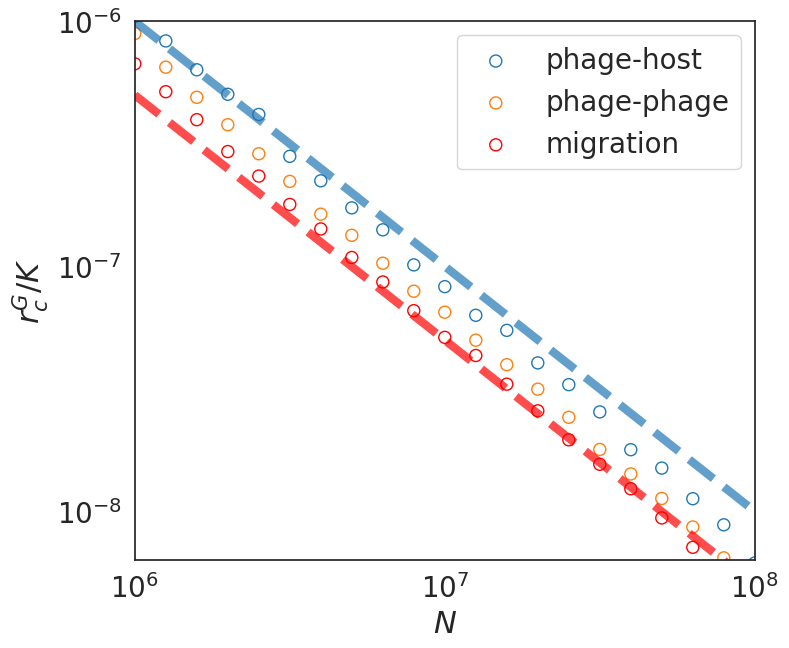

In [22]:
L = 20
d = 2
K = L*(L-1)/2
N = np.logspace(6.0, 8.0, num=100) 
c = tableau20[0]
df =pd.read_csv("Data4Plot/phase_critical_r_genotype.txt")
data = df[(df["L"]==L) & (df["d"]==d)]
plt.scatter(data.NX, data.rH_phagehost/K, label="phage-host", facecolors='none',edgecolors=c, marker="o", s=75)
plt.plot(N, 1/(N), linewidth = 6, color=c, linestyle="dashed",alpha=0.7)

c = tableau20[2]
df =pd.read_csv("Data4Plot/phase_critical_r_genotype_phagephage.txt")
data = df[(df["L"]==L) & (df["d"]==d)]
plt.scatter(data.NX, data.rH_phagephage/K, label="phage-phage", facecolors='none',edgecolors=c, marker="o", s=75)
#plt.plot(N, 1/(N), linewidth = 6, color=c, linestyle="dashed",alpha=0.7)

c = tableau20[4]
df =pd.read_csv("Data4Plot/phase_critical_r_genotype_random.txt")
data = df[(df["L"]==L) & (df["d"]==d)]
plt.scatter(data.NX, data.rH_random/K, label="migration", facecolors='none',edgecolors="red", marker="o", s=75)
#plt.plot(N, 1/(4*N), linewidth = 6, color=c, linestyle="dashed",alpha=0.7)
plt.plot(N, 1/(2*N), linewidth = 6, color="red", linestyle="dashed",alpha=0.7)

plt.xscale("log")
plt.yscale("log")
plt.legend( fontsize=20)
plt.xlabel(r"$N$",fontsize =22)
plt.ylabel(r"$r_c^G/K$",fontsize =22)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(10**6, 10**8)
plt.ylim(10**-8.2, 10**-6)
plt.savefig("critical_r_genotype_population_diff_gene_transfer.pdf", dpi=300, bbox_inches='tight')

# Figure S7: temperature for tripleton

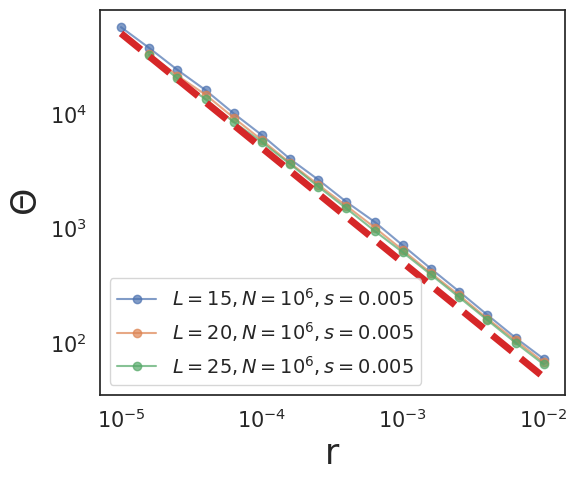

In [23]:
df =pd.read_csv("Data4Plot/tripleton_r.txt")
count = 0
for rname in ["rH_phagehost"]:
    for N in [10**6]:
        plt.figure(figsize=(6,5))
        for L in [15, 20, 25]:
            for J in  [0.005]: #set(df["J"]):
                data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                data = data.groupby(rname)["theta_GH"].mean()
                #print(data)
                x, y = data.index, data.values
                inds = np.argsort(x)
                #print(x, y)
                plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o", label=r"$L={0:d}, N=10^{1:d}, s={2:0.3f}$".format(int(L), int(np.log10(N)), J),alpha=0.7)
    x = np.logspace(-5,-2, 30)
    plt.plot(x, 1./(2*x),linewidth=5, linestyle="dashed", c= "tab:red")
    plt.xlabel("r",fontsize =25)
    plt.ylabel(r"$\Theta$",fontsize =25)
    #plt.title("genotype persistence time",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xscale("log")
    plt.yscale("log")
    #plt.xlim((10**-1.3, 5))
    #plt.ylim((0,10))
    if count>-1:
        plt.legend(fontsize=14)
        count +=1
    plt.savefig("Tripleton_GenotypeTheta"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

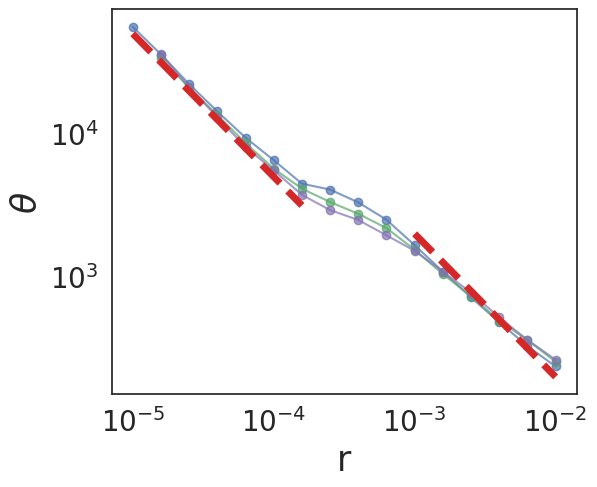

In [24]:
df =pd.read_csv("Data4Plot/tripleton_r.txt")
count = 0
for rname in ["rH_phagehost"]:
    for N in [10**6]:
        plt.figure(figsize=(6,5))
        for L in [15, 20,  25]:
            for J in  [0.005, 2]: #set(df["J"]):
                data = df[(df["L"] == L) & (df["J"] == J) & (df["NX"] == N) & (df[rname]!=0)]
                data = data.groupby(rname)["theta_gP"].mean()
                #print(data)
                x, y = data.index, data.values
                #x = data.index*N/L
                #y = N*(2*data.index)/(L)
                inds = np.argsort(x)
                #print(x, y)
                plt.plot(np.asarray(x)[inds], np.asarray(y)[inds], marker= "o", label=r"$L={0:d}, N=10^{1:d}, s={2:0.3f}$".format(int(L), int(np.log10(N)), J),alpha=0.7)
    x = np.logspace(-5,-3.8, 30)
    plt.plot(x, 1./(2*x),linewidth=5, linestyle="dashed", c= "tab:red")
    x = np.logspace(-3,-2, 30)
    plt.plot(x, 2./(x),linewidth=5, linestyle="dashed", c= "tab:red")
    plt.xlabel("r",fontsize =25)
    plt.ylabel(r"$\theta$",fontsize =25)
    #plt.title("genotype persistence time",fontsize =25)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xscale("log")
    plt.yscale("log")
    #plt.xlim((10**-1.3, 5))
    #plt.ylim((0,10))
    if count>-1:
       # plt.legend(fontsize=15)
        count +=1
    plt.savefig("Tripleton_Genetheta"+rname+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Figure S8: Critical values without population constraint

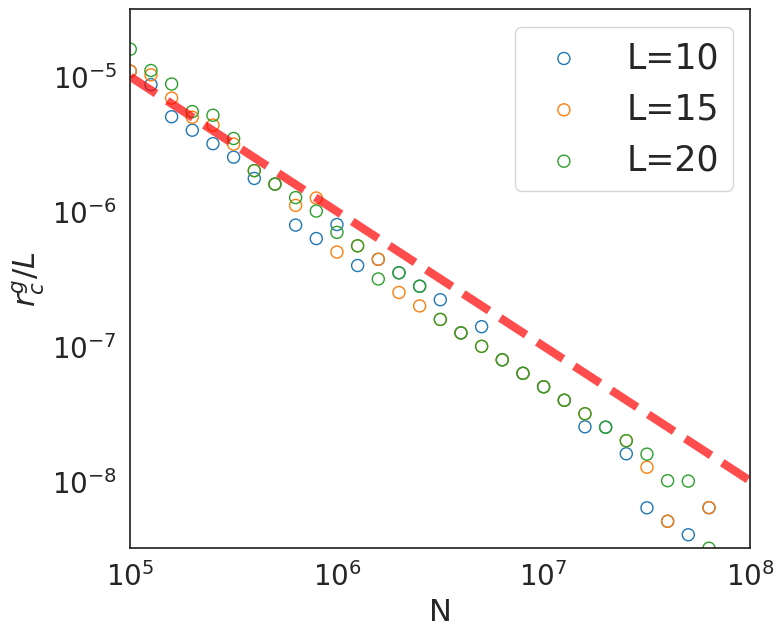

In [30]:
df =pd.read_csv("Data4Plot/phase_critical_r_gene_phagehost_no.txt")
i=0
for L in [10, 15, 20]:
    c = tableau20[i]
    i += 2
    d = 2
    data = df[(df["L"]==L) & (df["d"]==d)]
    scatter = plt.scatter(data.NX, data.rH_phagehost/L, label="L="+str(L), facecolors='none',edgecolors=c, marker="o", s=75)
N = np.logspace(5.0, 8.0, num=100)
plt.plot(N, 1/(N), linewidth = 6, color="red", linestyle="dashed",alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("N",fontsize =22)
plt.ylabel(r"$r_c^g/L$",fontsize =22)
plt.legend(fontsize=25)
plt.xlim(10**5, 10**8)
plt.ylim(10**-8.5, 10**-4.5)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("critical_r_gene_population_constraint.pdf", dpi=300, bbox_inches='tight')
#plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

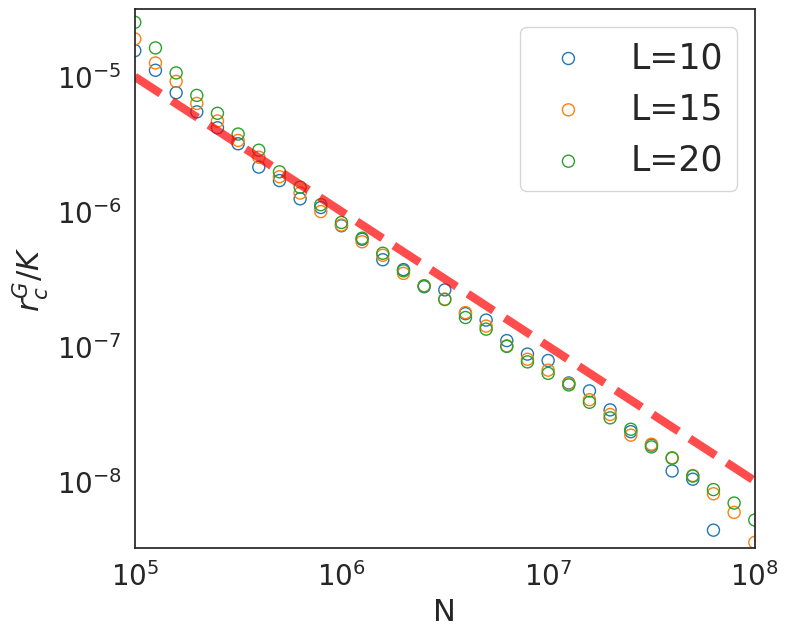

In [26]:
df =pd.read_csv("Data4Plot/phase_critical_r_genotype_phagehost_no.txt")
i=0
for L in [10, 15, 20]:
    c = tableau20[i]
    i += 2
    d = 2
    data = df[(df["L"]==L) & (df["d"]==d)]
    K = L*(L-1)/2
    scatter = plt.scatter(data.NX, data.rH_phagehost/K, label="L="+str(L), facecolors='none',edgecolors=c, marker="o", s=75)
N = np.logspace(5.0, 8.0, num=100)
plt.plot(N, 1/(N), linewidth = 6, color="red", linestyle="dashed",alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("N",fontsize =22)
plt.ylabel(r"$r_c^G/K$",fontsize =22)
plt.legend(fontsize=25)
plt.xlim(10**5, 10**8)
plt.ylim(10**-8.5, 10**-4.5)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("critical_r_genotype_population_constraint.pdf", dpi=300, bbox_inches='tight')
#plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))